In [3]:
import pandas as pd
from ggplot import *

project_id = "the-d-team-164512"

In [8]:
query = """\
SELECT
  d.BrandName AS brand_name
  , DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE d.brandName = 'LIPITOR'
GROUP BY
  brand_name
  , year_month
ORDER BY
  brand_name
  , year_month ASC"""

df_lipitor = pd.read_gbq(query, project_id)
df_lipitor.head(3)

Waiting for job to complete...


,brand_name,year_month,transaction_count
0,LIPITOR,2010-12-01,102
1,LIPITOR,2011-01-01,53268
2,LIPITOR,2011-02-01,47289


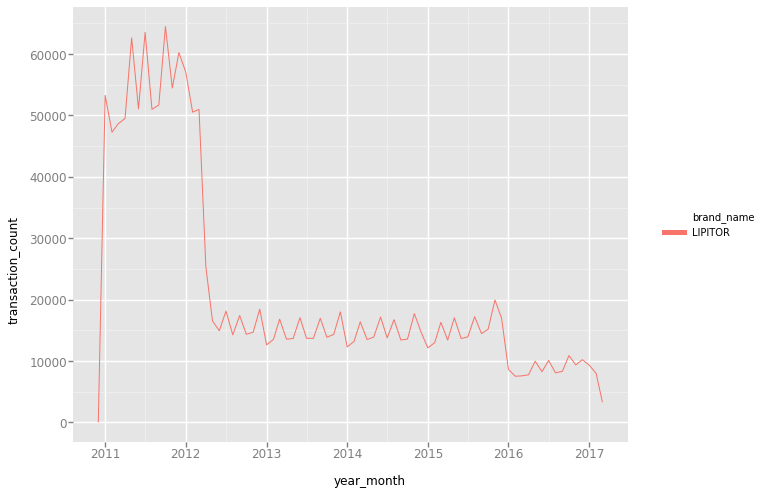

<ggplot: (-9223372036574669778)>

In [9]:
df_lipitor.year_month = pd.Series(df_lipitor.year_month).apply(pd.to_datetime, format='%Y-%m')
ggplot(
    aes(x='year_month', y='transaction_count', colour='brand_name'),
    data=df_lipitor) +\
    geom_line()

In [12]:
query = """\
SELECT
  d.ATCLevel5Code
  , d.BrandName AS brand_name
  , (CASE WHEN d.BrandName = 'LIPITOR' THEN 'LIPITOR' ELSE 'NON LIPITOR' END) AS lipitor
  , DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE d.ATCLevel5Code = 'C10AA05'
GROUP BY
  d.ATCLevel5Code
  , brand_name
  , lipitor
  , year_month
ORDER BY
  d.ATCLevel5Code
  , brand_name
  , year_month ASC
"""
df_rpl = pd.read_gbq(query, project_id)
df_rpl.head(3)

Waiting for job to complete...


,d_ATCLevel5Code,brand_name,lipitor,year_month,transaction_count
0,C10AA05,ATORVACHOL,NON LIPITOR,2012-05-01,24
1,C10AA05,ATORVACHOL,NON LIPITOR,2012-06-01,561
2,C10AA05,ATORVACHOL,NON LIPITOR,2012-07-01,1064


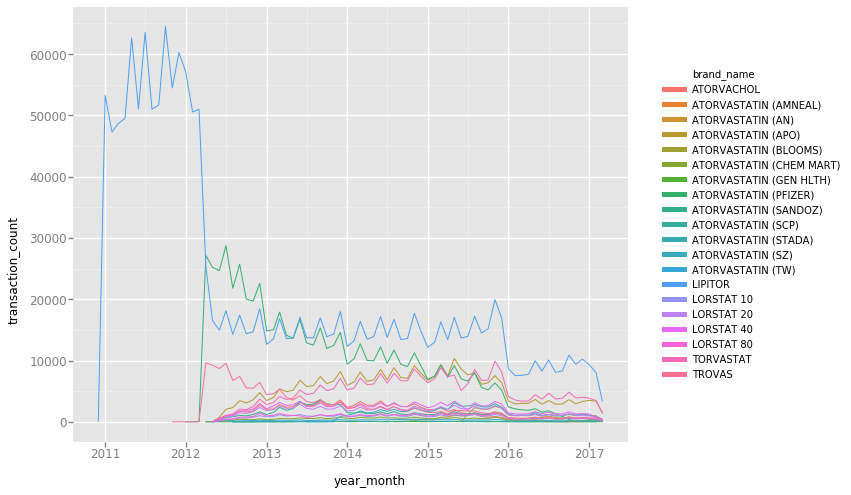

<ggplot: (281796861)>

In [13]:
df_rpl.year_month = pd.Series(df_rpl.year_month).apply(pd.to_datetime, format='%Y-%m')
ggplot(
    aes(x='year_month', y='transaction_count', colour='brand_name'),
    data=df_rpl) +\
    geom_line()

## Lipitor out of patent Nov 2011
As Lipitor goes [out of patent](https://en.wikipedia.org/wiki/Atorvastatin) it is replaced by other statins predominangly versions of atorvastatin.

* who is the first to pick this up? by store? by geography?
* what is the cost impact?
* surprisingly there is no increase in useage?

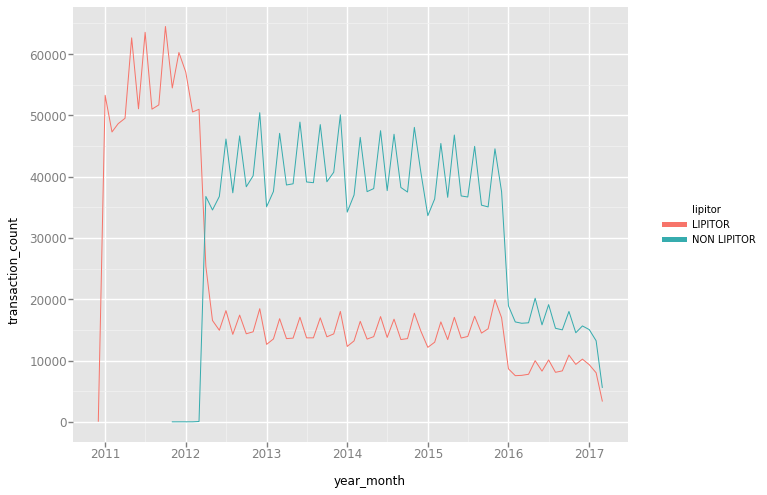

<ggplot: (-9223372036571927573)>

In [40]:
df_lip = df_rpl.groupby(['year_month', 'lipitor']).sum()    
df_lip.reset_index(inplace=True)
df_lip
ggplot(
    aes(x='year_month', y='transaction_count', colour='lipitor'),
    data=df_lip) +\
    geom_line()

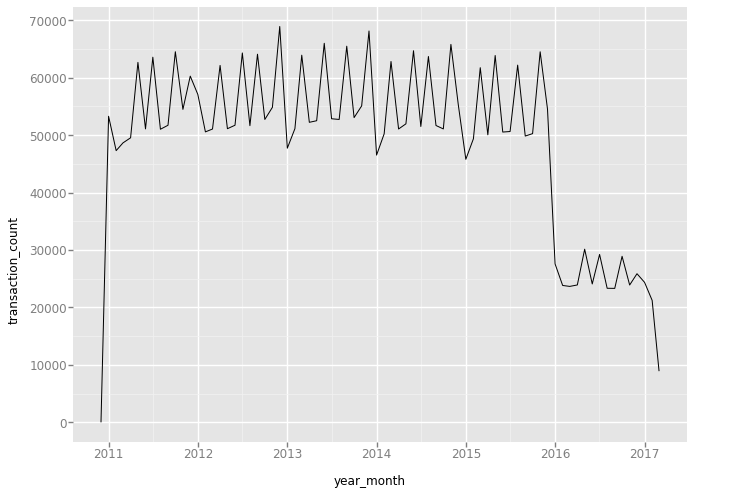

<ggplot: (283443264)>

In [53]:
df_lip_all = df_rpl.groupby(['year_month']).sum()    
df_lip_all.reset_index(inplace=True)
ggplot(
    aes(x='year_month', y='transaction_count'),
    data=df_lip_all) +\
    geom_line(position = 'stack')

In [11]:
query = """\
SELECT
  d.ATCLevel5Code
  , d.BrandName AS brand_name
  , (CASE WHEN d.BrandName = 'LIPITOR' THEN 'LIPITOR' ELSE 'NON LIPITOR' END) AS lipitor
  , DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , COUNT(*) AS transaction_count
  , SUM(pcd.distance) AS cumulative_store_distance
  , SUM(t.PatientPrice_Amt) AS cumulative_patient_price
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
JOIN dthon.patients_lookup p
ON t.patient_id = p.patient_id
JOIN dthon.stores_lookup s
ON s.store_id = t.store_id
JOIN dthon.postcode_distances pcd
ON p.postcode = pcd.from_postcode AND s.postcode = pcd.to_postcode
WHERE d.ATCLevel5Code = 'C10AA05'
GROUP BY
  d.ATCLevel5Code
  , brand_name
  , lipitor
  , year_month
ORDER BY
  d.ATCLevel5Code
  , brand_name
  , year_month ASC
"""

df_dist_price = pd.read_gbq(query, project_id)
df_dist_price.head(3)

Waiting for job to complete...
Waiting for job to complete...
Waiting for job to complete...


,d_ATCLevel5Code,brand_name,lipitor,year_month,transaction_count,cumulative_store_distance,cumulative_patient_price
0,C10AA05,ATORVACHOL,NON LIPITOR,2012-05-01,24,964.671328,216.40
1,C10AA05,ATORVACHOL,NON LIPITOR,2012-06-01,561,9061.368349,5003.55
2,C10AA05,ATORVACHOL,NON LIPITOR,2012-07-01,1064,24759.402784,8468.99


In [12]:
df_dist_price.year_month = pd.Series(df_dist_price.year_month).apply(pd.to_datetime, format='%Y-%m')

**There must be something wrong in my query?**
* Why is the price of non-lipitor so much higher then lipitor?
* why does the non-lipitor price vary so much?

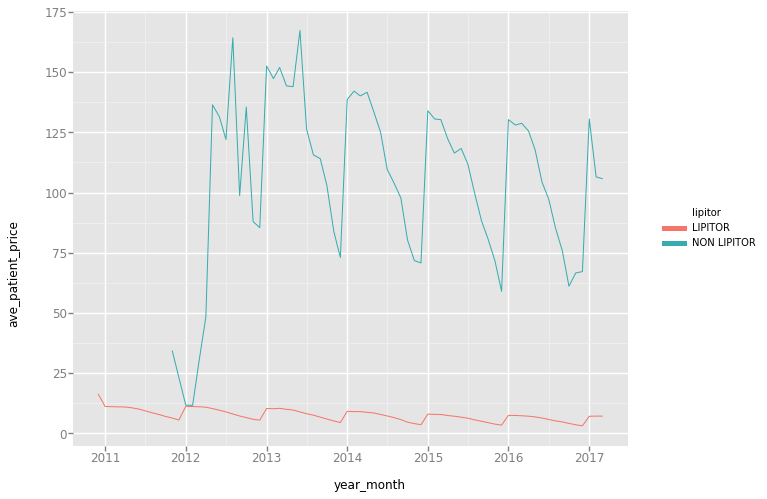

<ggplot: (292296063)>

In [25]:
df_dist_price['ave_store_distance'] = df_dist_price.cumulative_store_distance / df_dist_price.transaction_count
df_dist_price['ave_patient_price'] = df_dist_price.cumulative_patient_price / df_dist_price.transaction_count
df_l_d_p = df_dist_price.groupby(['year_month', 'lipitor']).sum()    
df_l_d_p.reset_index(inplace=True)
df_l_d_p
ggplot(
    aes(x='year_month', y='ave_patient_price', colour='lipitor'),
    data=df_l_d_p) +\
    geom_line()

**There has to be something wrong in my query?**
* why would the distance for non lipitor jump so high?
* are they being ordered from further away?
* or is there a miscalculation?

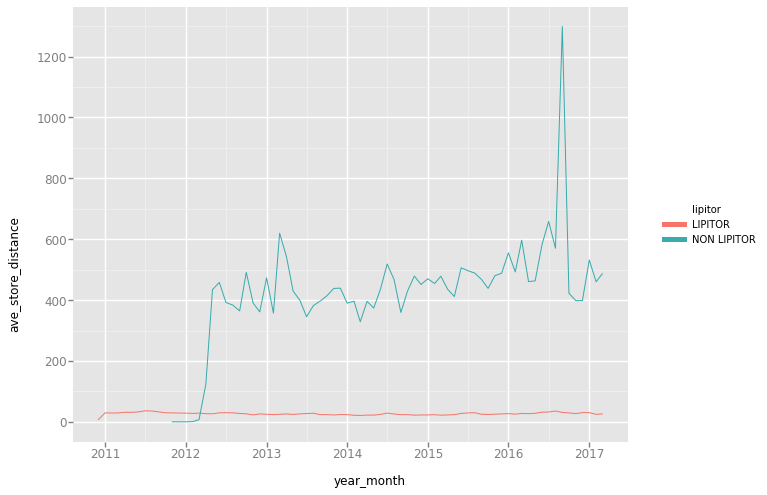

<ggplot: (-9223372036562479637)>

In [26]:
ggplot(
    aes(x='year_month', y='ave_store_distance', colour='lipitor'),
    data=df_l_d_p) +\
    geom_line()

In [27]:
query = """\
SELECT
  d.ATCLevel5Code
  , a.ATCLevel5Name
  , DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , SUM(pcd.distance) AS sum_distance
  , SUM(t.PatientPrice_Amt) AS sum_price
  , count(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
JOIN dthon.patients_lookup p
ON t.patient_id = p.patient_id
JOIN dthon.stores_lookup s
ON s.store_id = t.store_id
JOIN dthon.postcode_distances pcd
ON p.postcode = pcd.from_postcode AND s.postcode = pcd.to_postcode
JOIN dthon.atc_lookup a
ON a.ATCLevel5Code = d.ATCLevel5Code
WHERE
  d.ATCLevel5Code IN ('C10AA07', 'N02BE01', 'C10AA05', 'A02BC05', 'C09AA04', 'C09CA07', 'R03BB04', 'C07AB03', 'C09CA06', 'A02BC02')
GROUP BY
  d.ATCLevel5Code
  , a.ATCLevel5Name
  , year_month
ORDER BY
  d.ATCLevel5Code
  , year_month ASC
"""

df_pop = pd.read_gbq(query, project_id)
df_pop.year_month = pd.Series(df_pop.year_month).apply(pd.to_datetime, format='%Y-%m')
df_pop.head(3)

Waiting for job to complete...


,d_ATCLevel5Code,a_ATCLevel5Name,year_month,sum_distance,sum_price,transaction_count
0,A02BC02,PANTOPRAZOLE,2010-12-01,1951.415201,431.13,37
1,A02BC02,PANTOPRAZOLE,2011-01-01,655120.404133,183076.65,19643
2,A02BC02,PANTOPRAZOLE,2011-02-01,523389.154006,162517.40,17628


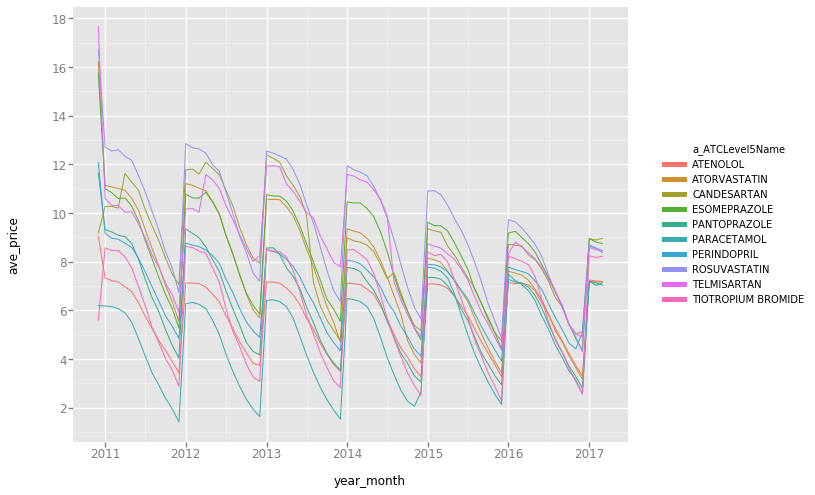

<ggplot: (293080980)>

In [31]:
df_pop['ave_distance'] = df_pop.sum_distance / df_pop.transaction_count
df_pop['ave_price'] = df_pop.sum_price / df_pop.transaction_count
ggplot(
    aes(x='year_month', y='ave_price', colour='a_ATCLevel5Name'),
    data=df_pop) +\
    geom_line()